In [6]:
import pandas as pd
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=150, color_map='viridis')
sc.logging.print_versions()
out_path = "/home/kevin/rimod/RNAseq/analysis/deconvolution/cell_type_specificity/"
num_top_genes = 100

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [7]:
path = "/home/kevin/deepcell_project/revision1_september19/rosmap_deconvolution/training_data/GSE67835_count_table.txt"
adata = sc.read_text(path).T
adata

AnnData object with n_obs × n_vars = 466 × 22088 

In [8]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=5)
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata

filtered out 3946 genes that are detectedin less than 5 cells


AnnData object with n_obs × n_vars = 466 × 18142 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

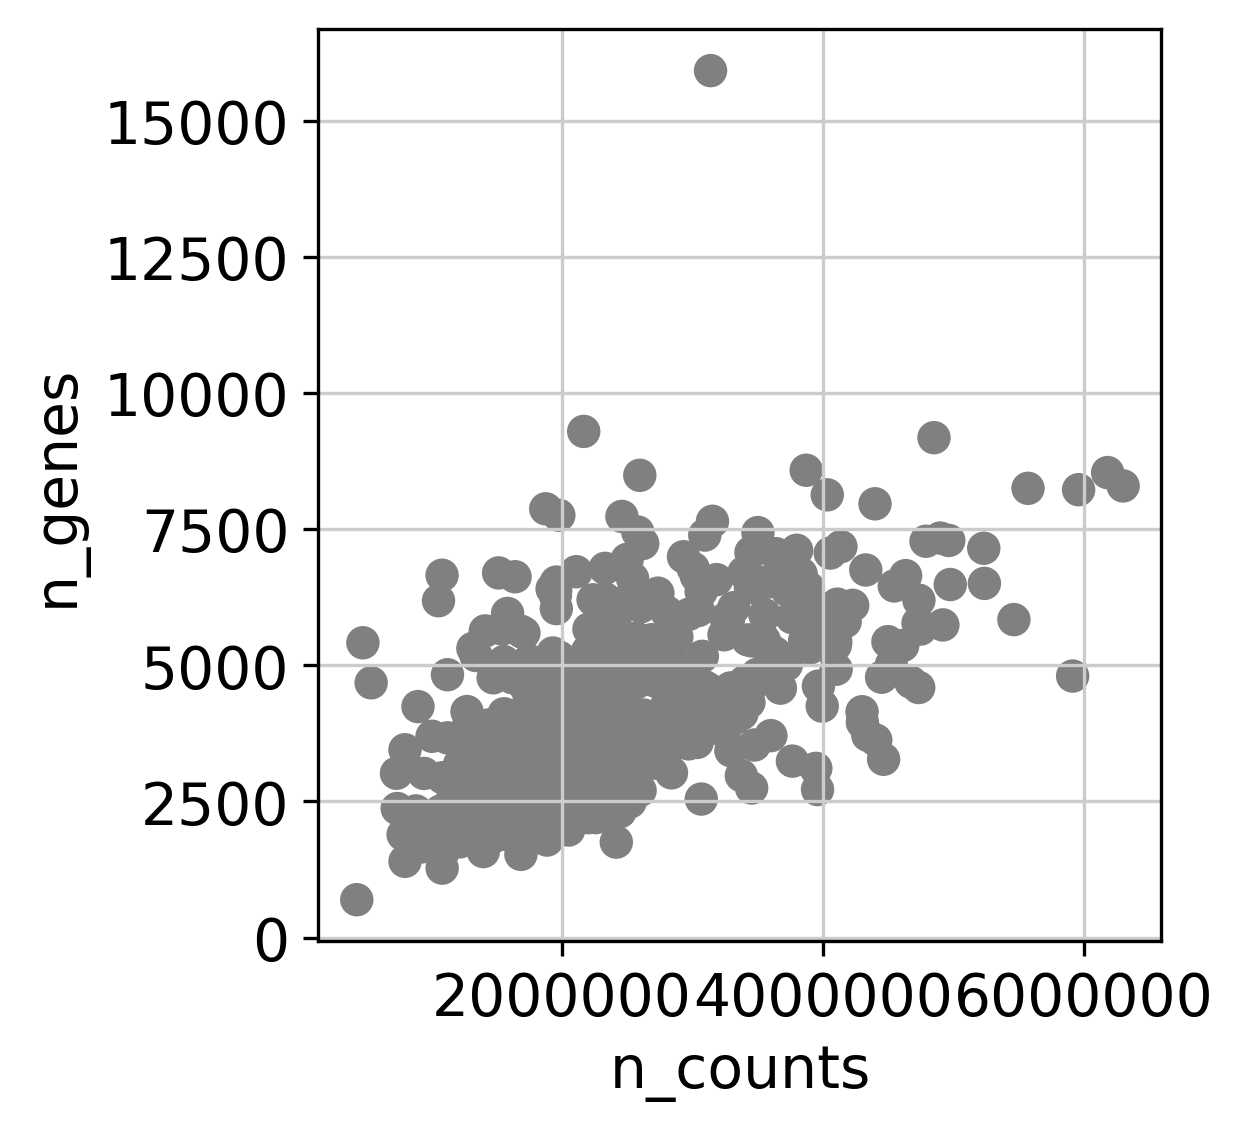

In [9]:
sc.pl.scatter(adata, x="n_counts", y='n_genes')

In [10]:
adata = adata[adata.obs['n_genes'] < 12500, :]
#adata = adata[adata.obs['n_counts'] < 4500, :]
adata.raw = sc.pp.log1p(adata, copy=True)
adata

AnnData object with n_obs × n_vars = 465 × 18142 
    obs: 'n_genes', 'n_counts'
    var: 'n_cells'

In [11]:
 # Normalize per cell
sc.pp.normalize_per_cell(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [12]:
 # Save the complete matrix
df = pd.DataFrame(adata.X)
df.columns = adata.var.index
#df.to_csv(out_path + "GSE67835_norm_counts_all.txt", sep="\t")

extracting highly variable genes
    finished (0:00:01)


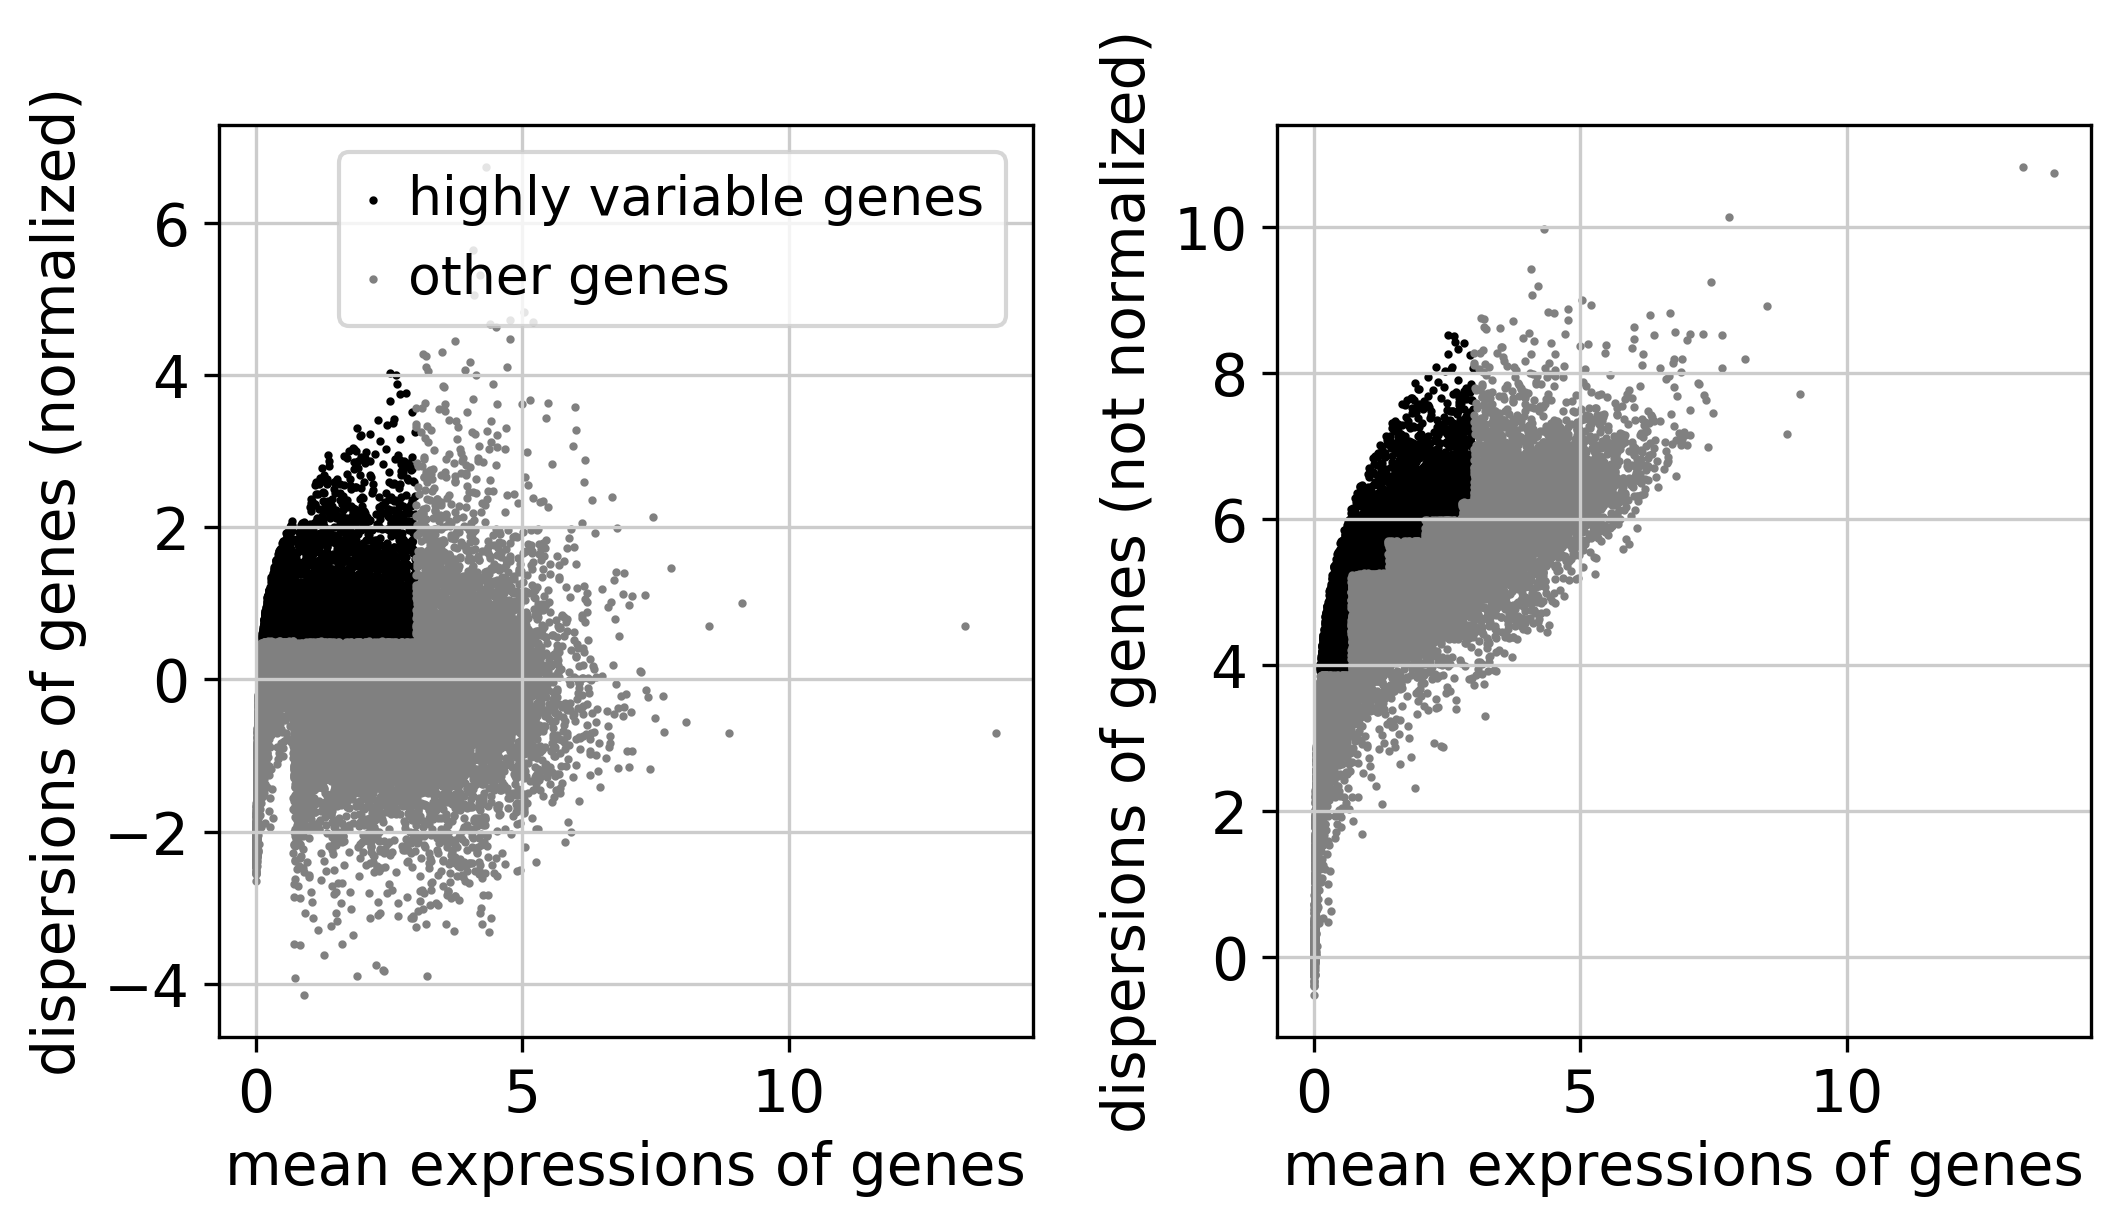

In [13]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [14]:
adata = adata[:, filter_result.gene_subset]
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
regressing out ['n_counts']
    finished (0:00:10)


In [15]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)
    finished (0:00:02)
computing UMAP
    finished (0:00:02)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:03)


In [16]:
sc.tl.louvain(adata, resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


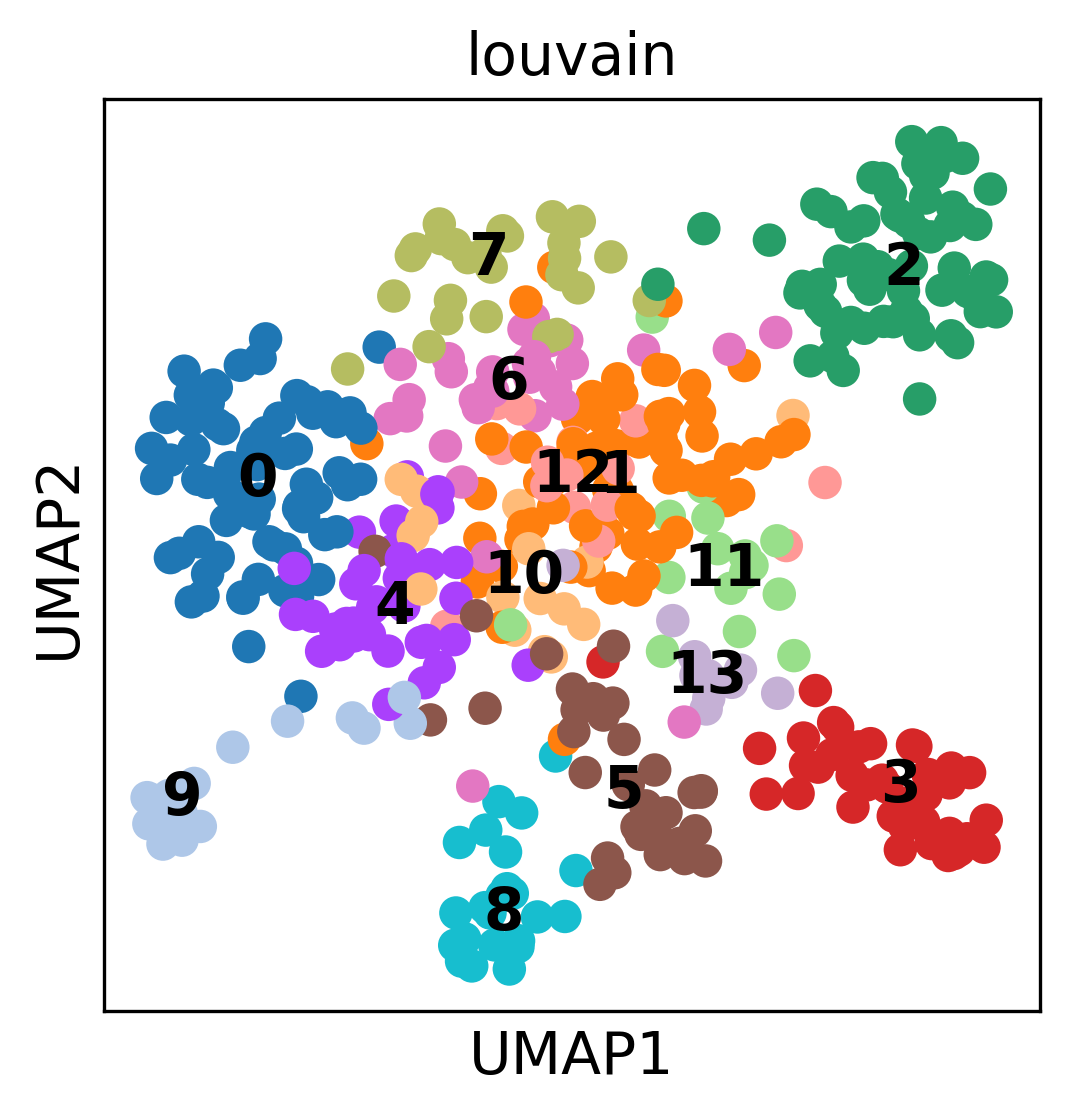

In [17]:
sc.pl.umap(adata, color='louvain', legend_loc='on data')

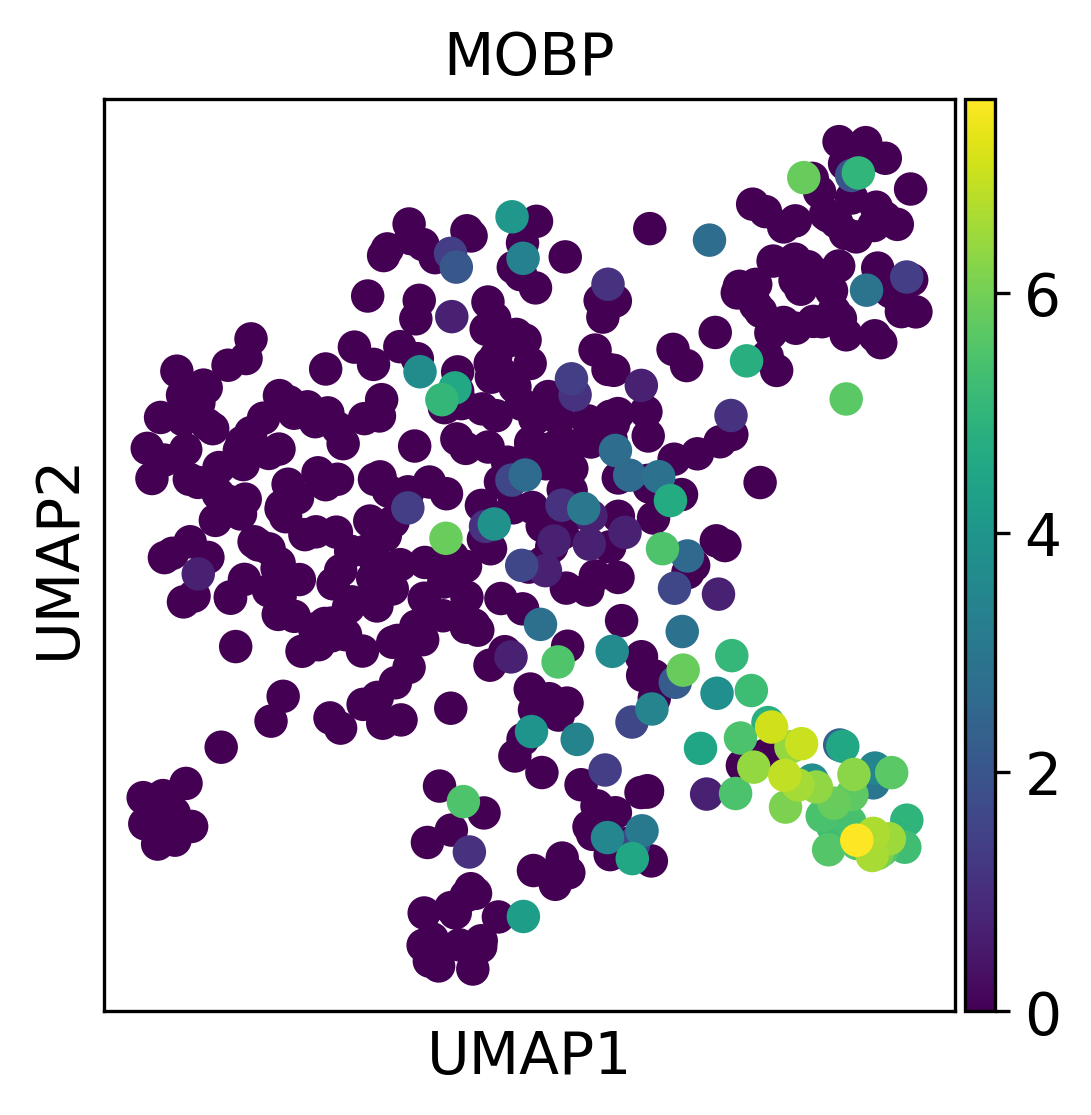

In [18]:
# Oligodendrocytes
sc.pl.umap(adata, color='MOBP')

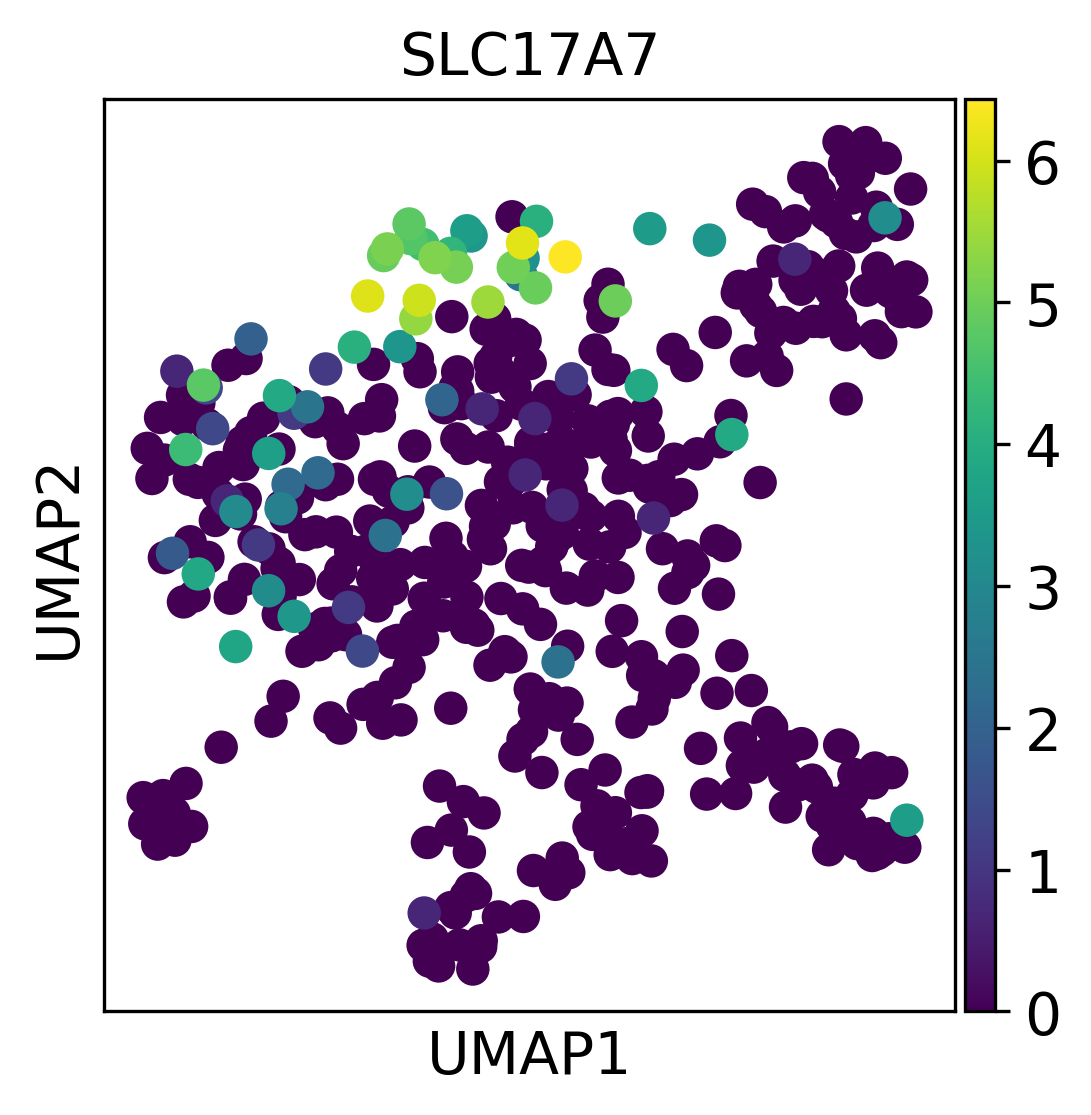

In [19]:
# Ex-Neurons
sc.pl.umap(adata, color='SLC17A7')

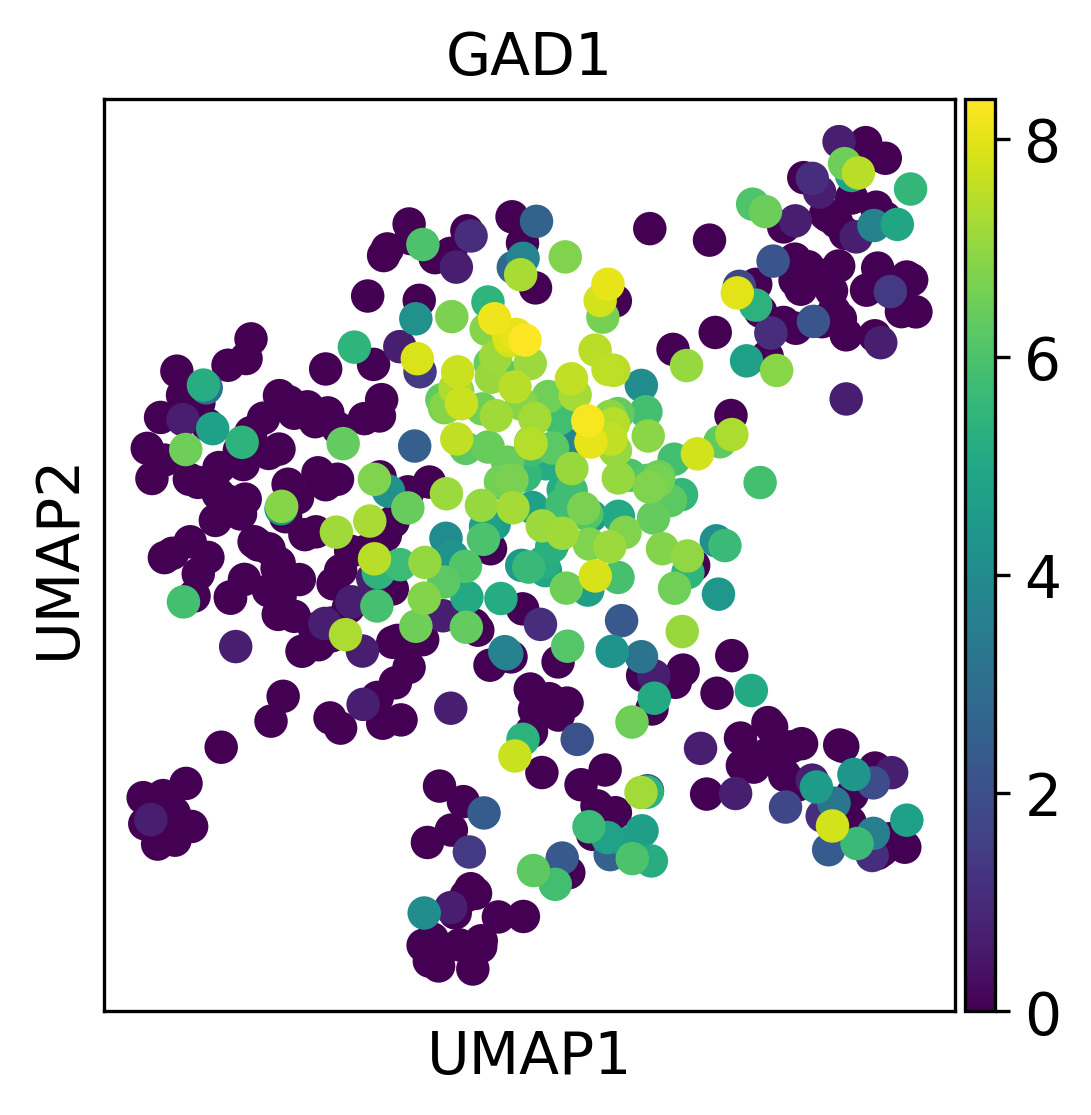

In [20]:
# In-Neurons
sc.pl.umap(adata, color='GAD1')

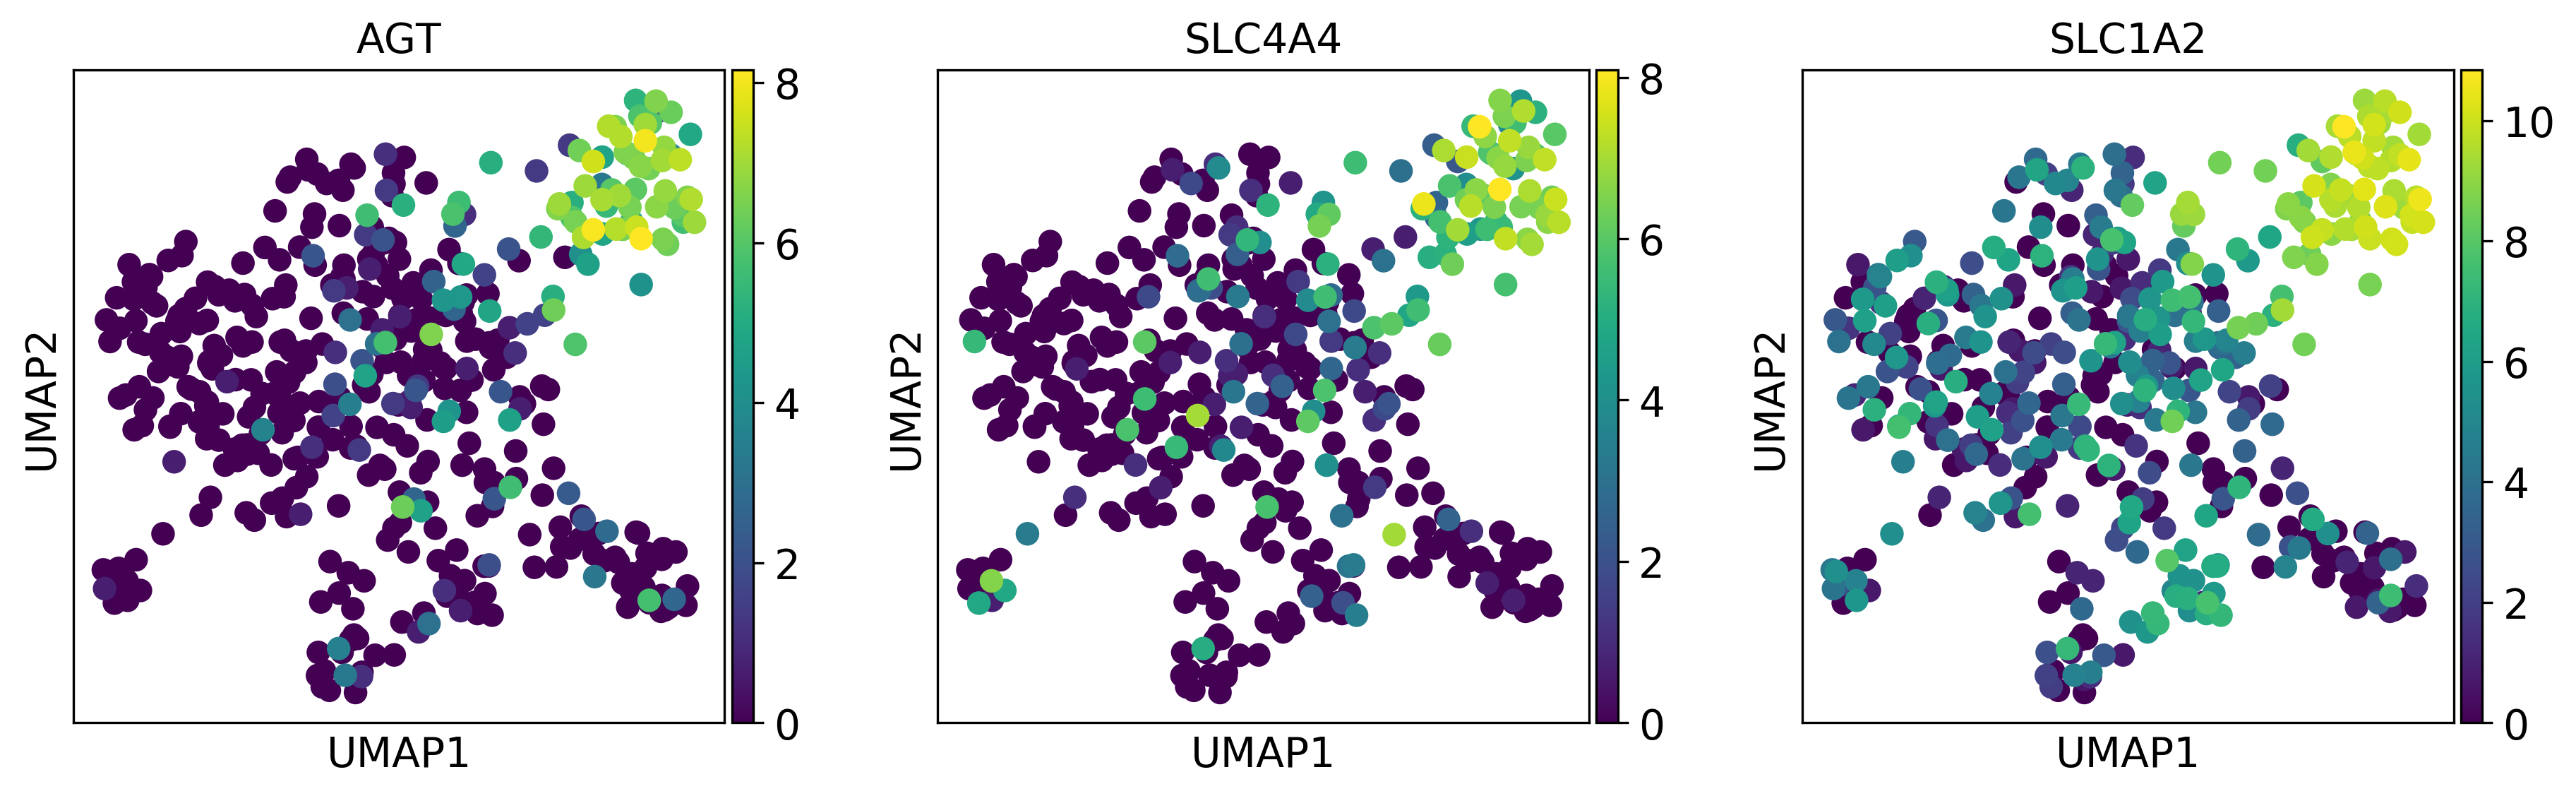

In [21]:
# Astrocytes
sc.pl.umap(adata, color=['AGT', 'SLC4A4', 'SLC1A2'])

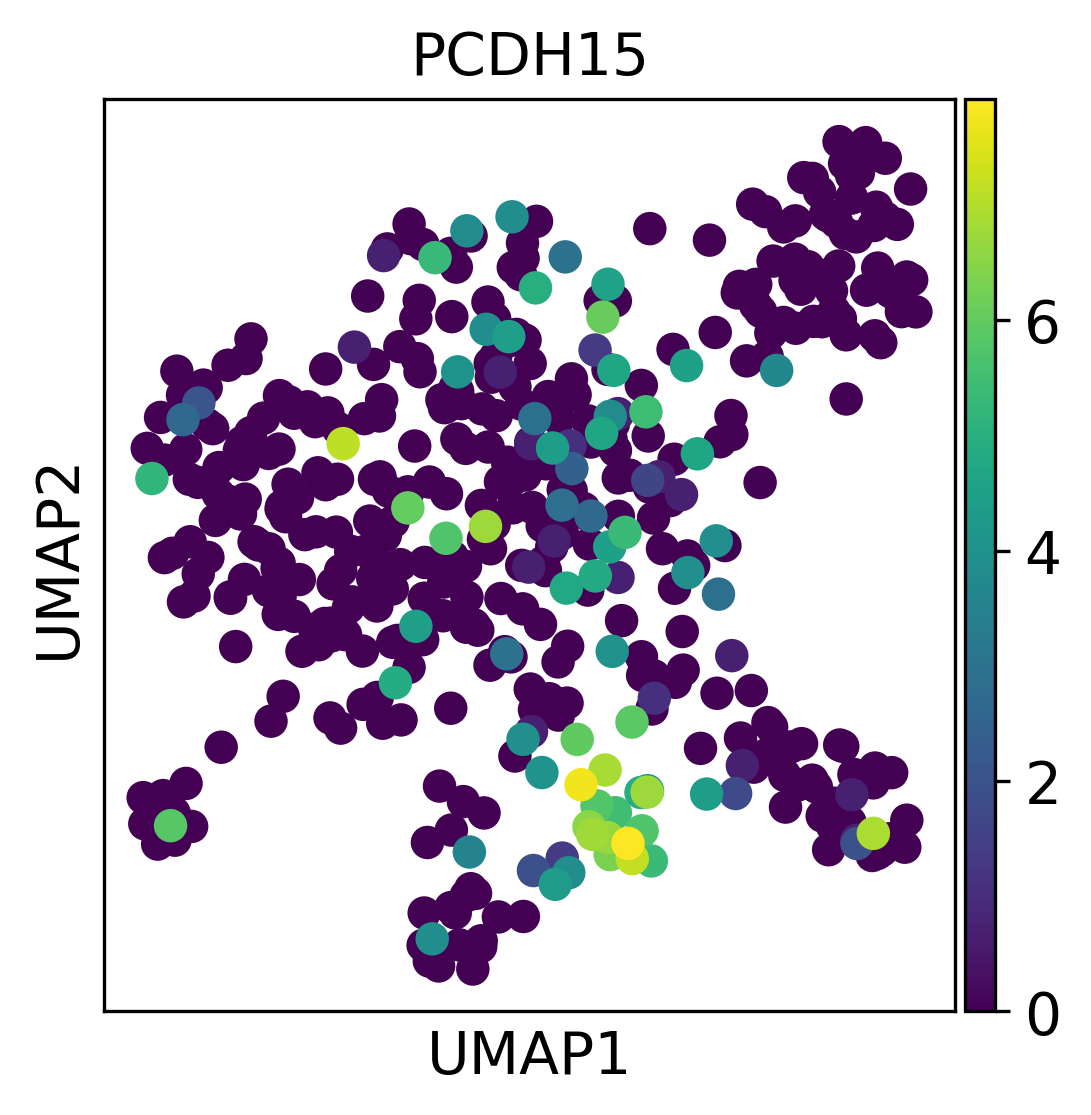

In [22]:
# OPC
sc.pl.umap(adata, color='PCDH15')

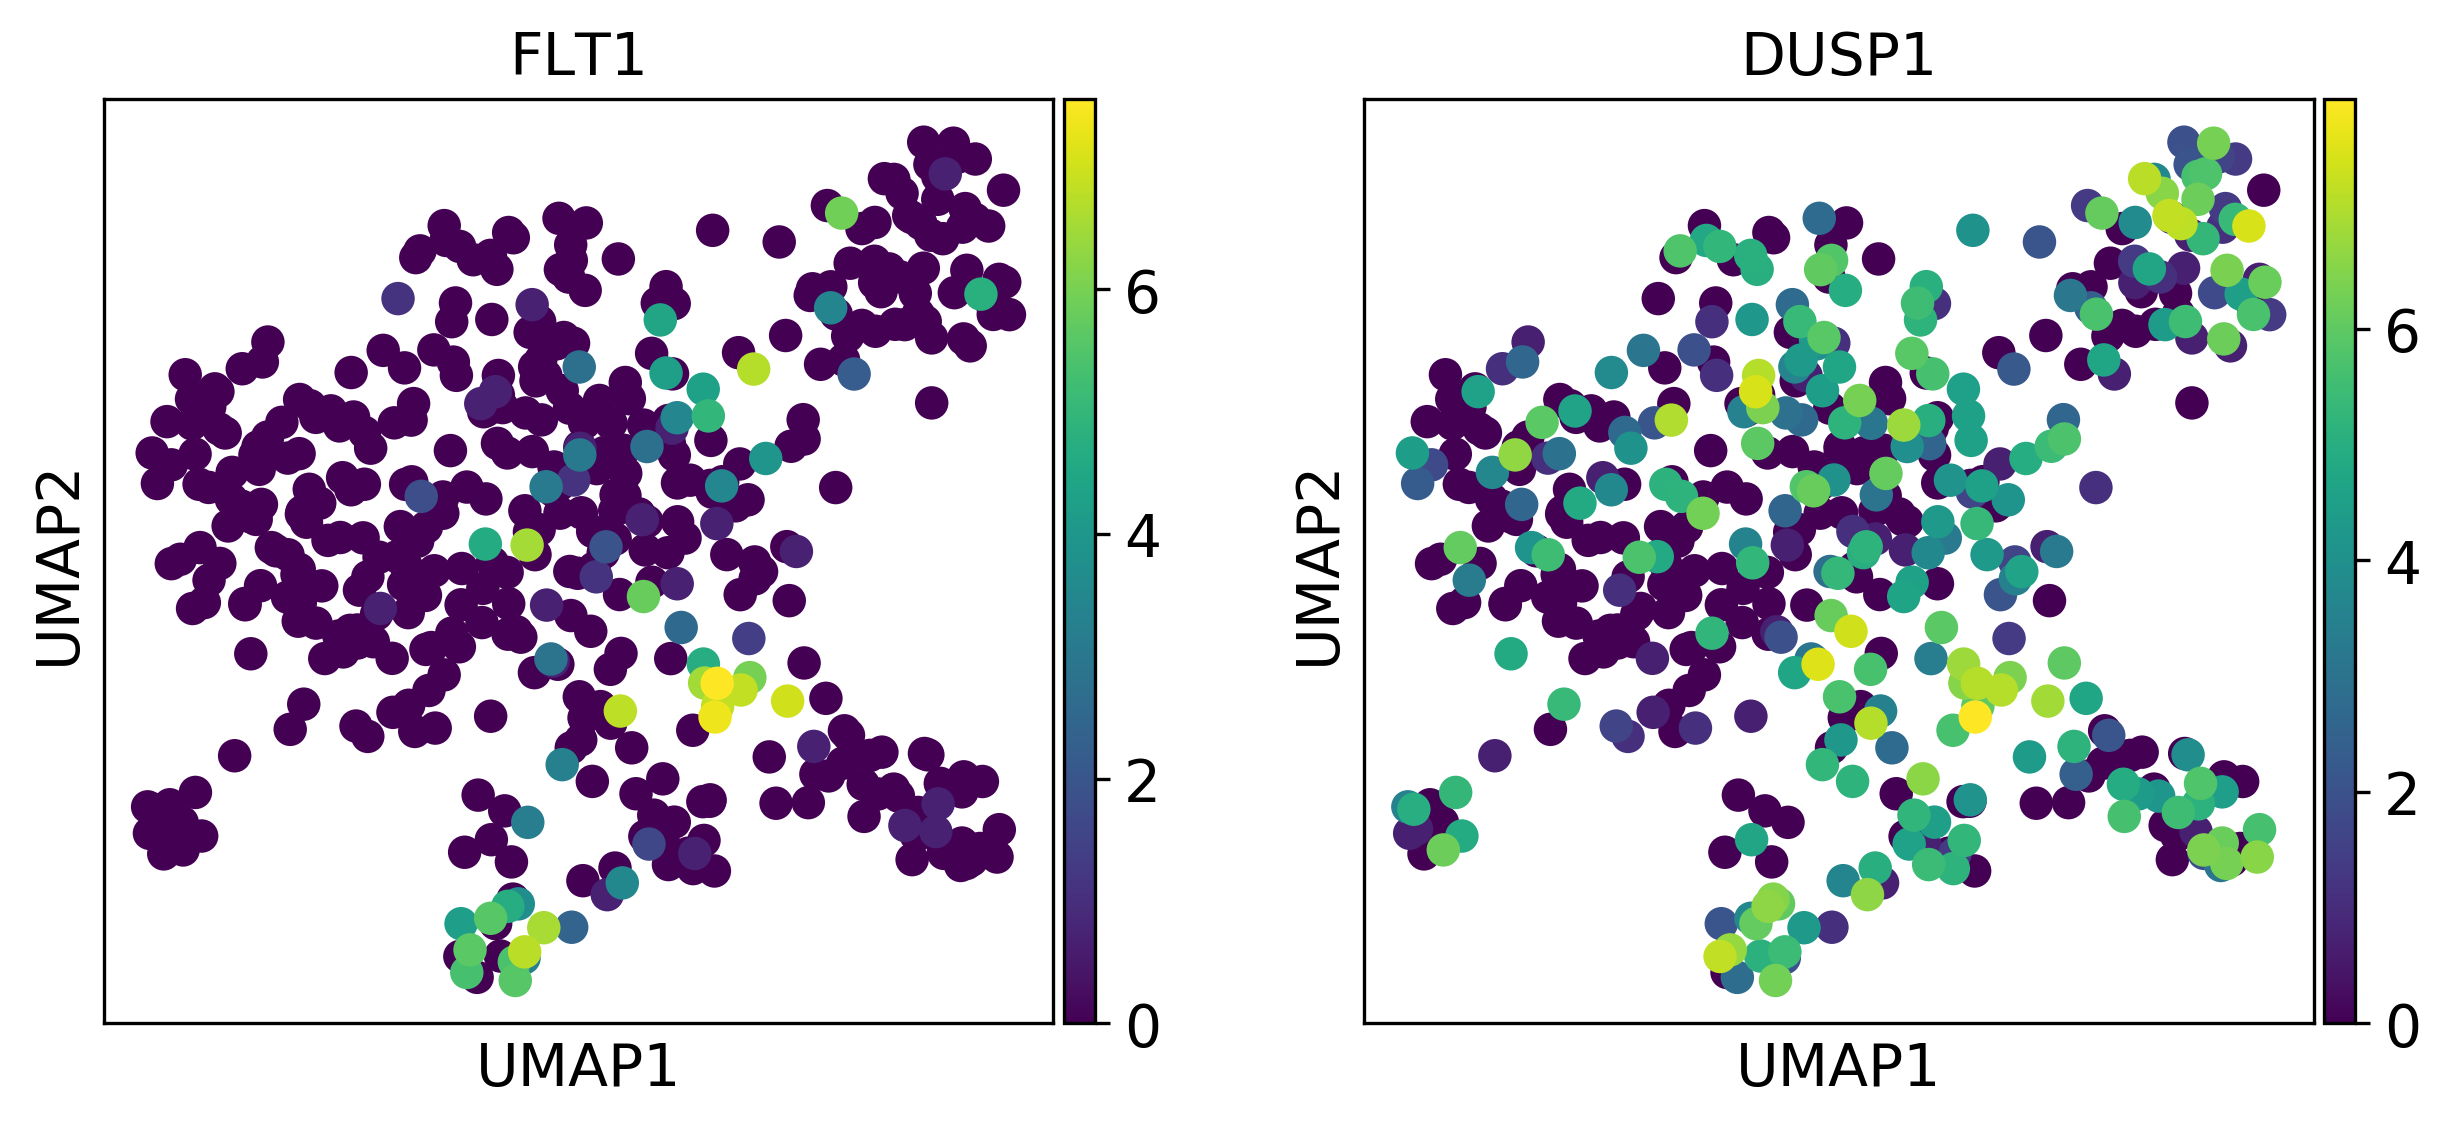

In [23]:
# Endothelial
sc.pl.umap(adata, color=['FLT1', 'DUSP1'])

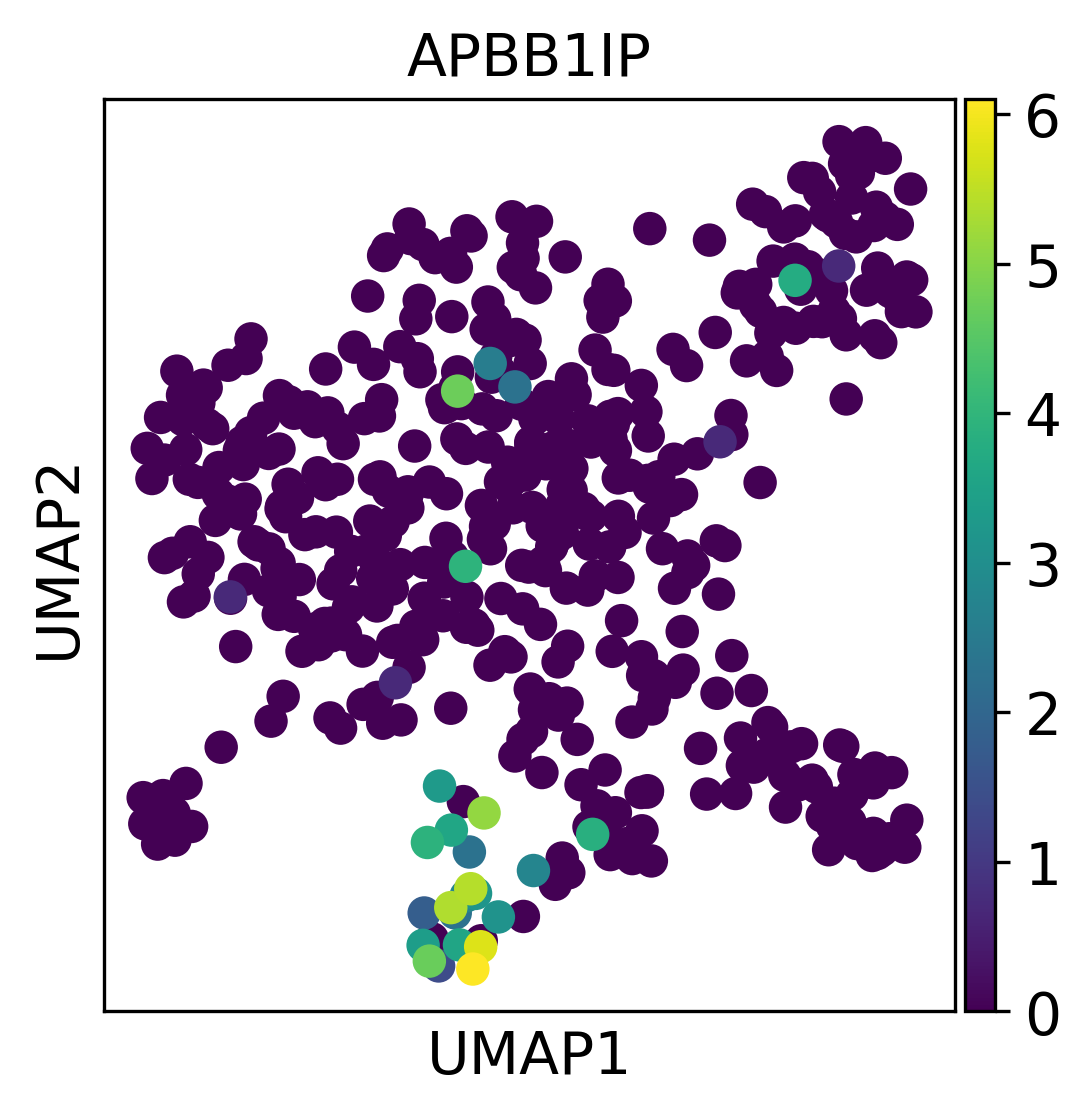

In [24]:
# Microglia
sc.pl.umap(adata, color=['APBB1IP'])

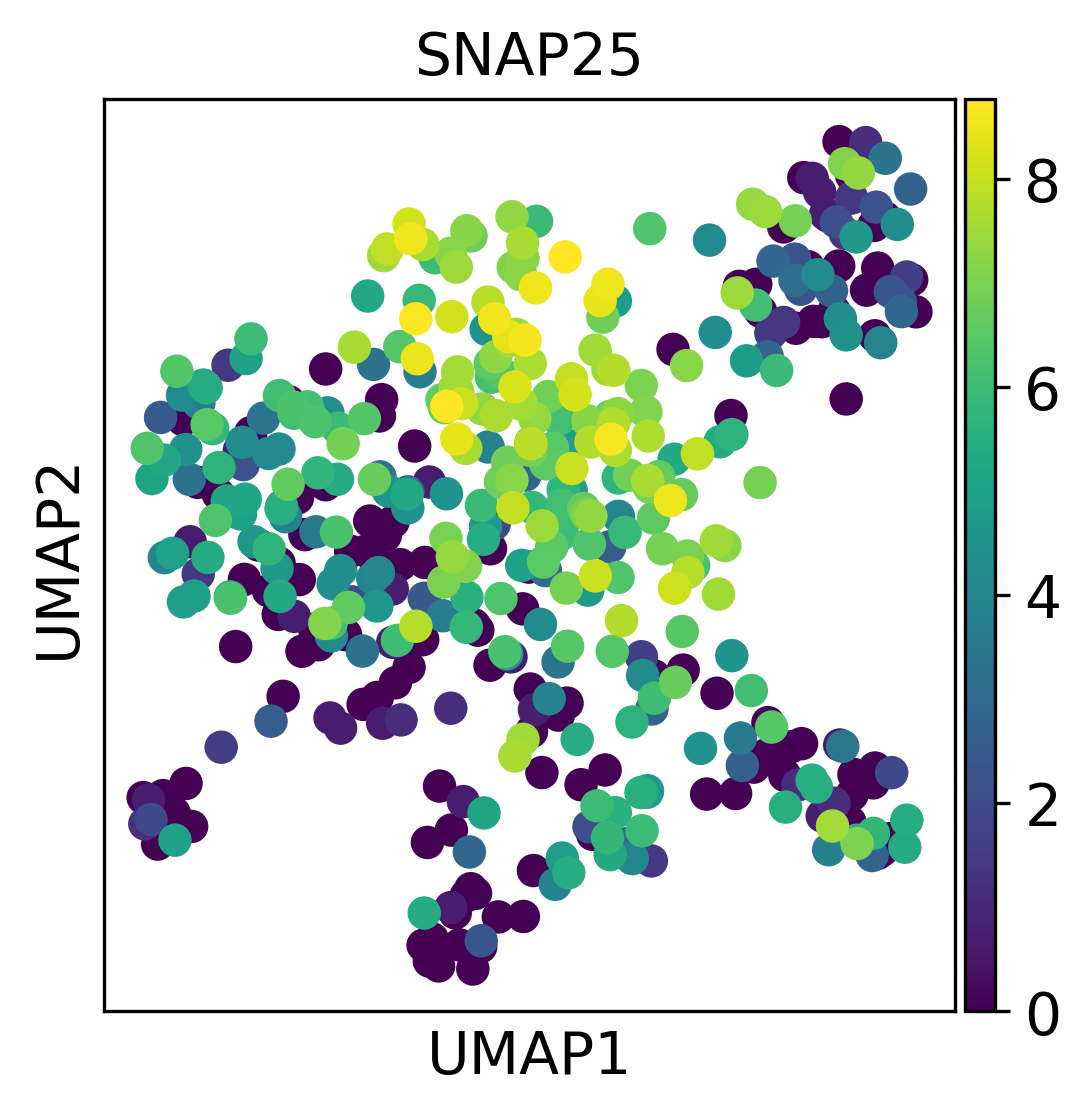

In [25]:
sc.pl.umap(adata, color=['SNAP25'])

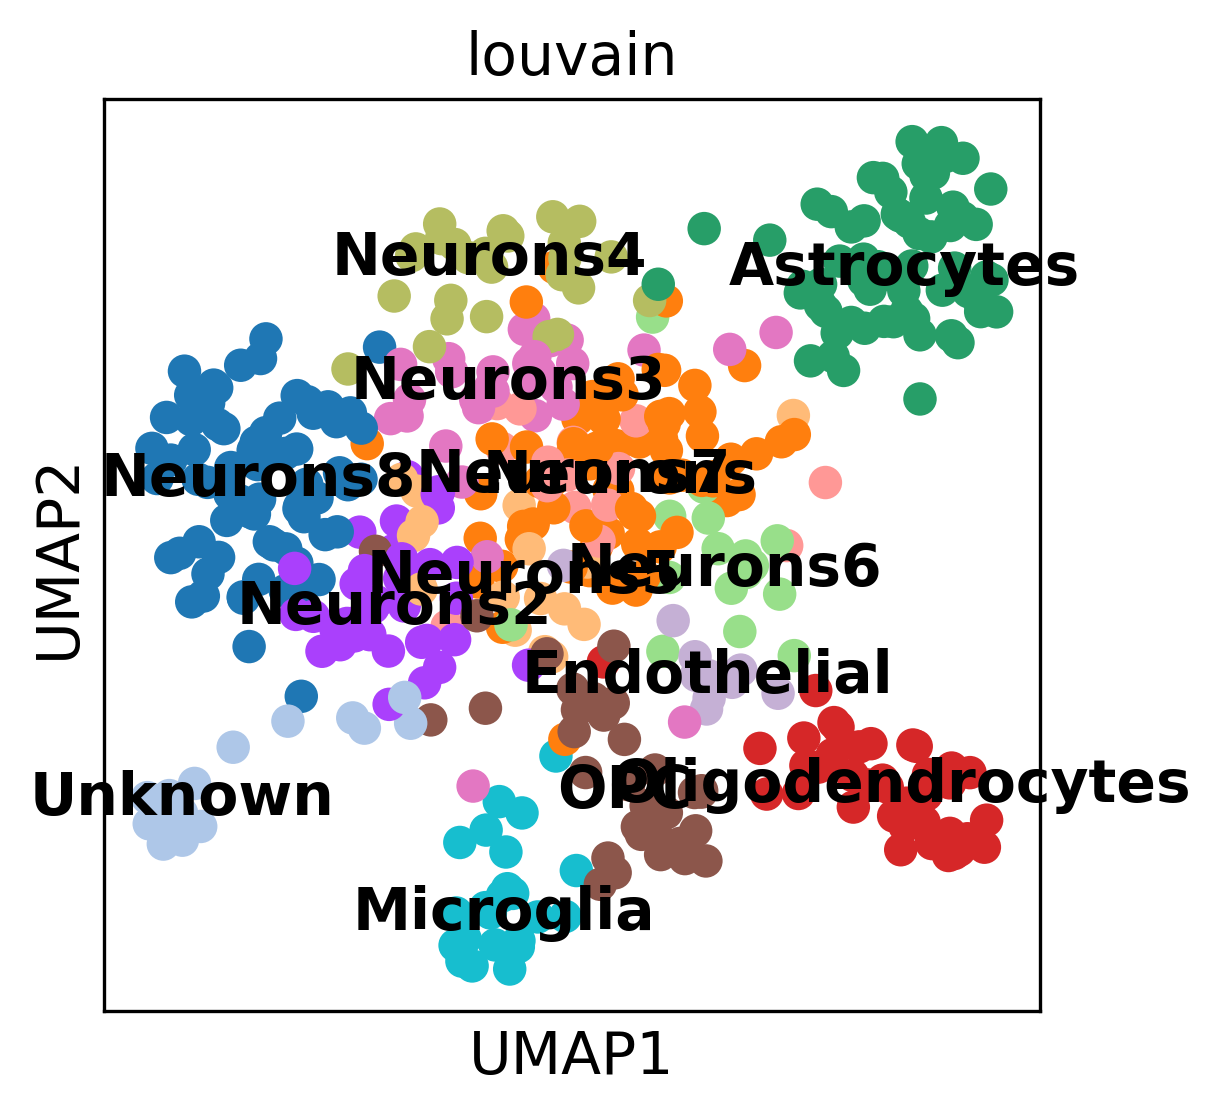

In [31]:
new_celltypes = ['Neurons8', 'Neurons', 'Astrocytes', 'Oligodendrocytes', 'Neurons2',
                'OPC', 'Neurons3', 'Neurons4', 'Microglia',
                'Unknown', 'Neurons5', 'Neurons6', 'Neurons7', 'Endothelial']
adata.rename_categories('louvain', new_celltypes)
sc.pl.umap(adata, color='louvain', legend_loc='on data')

... storing 'celltype' as categorical


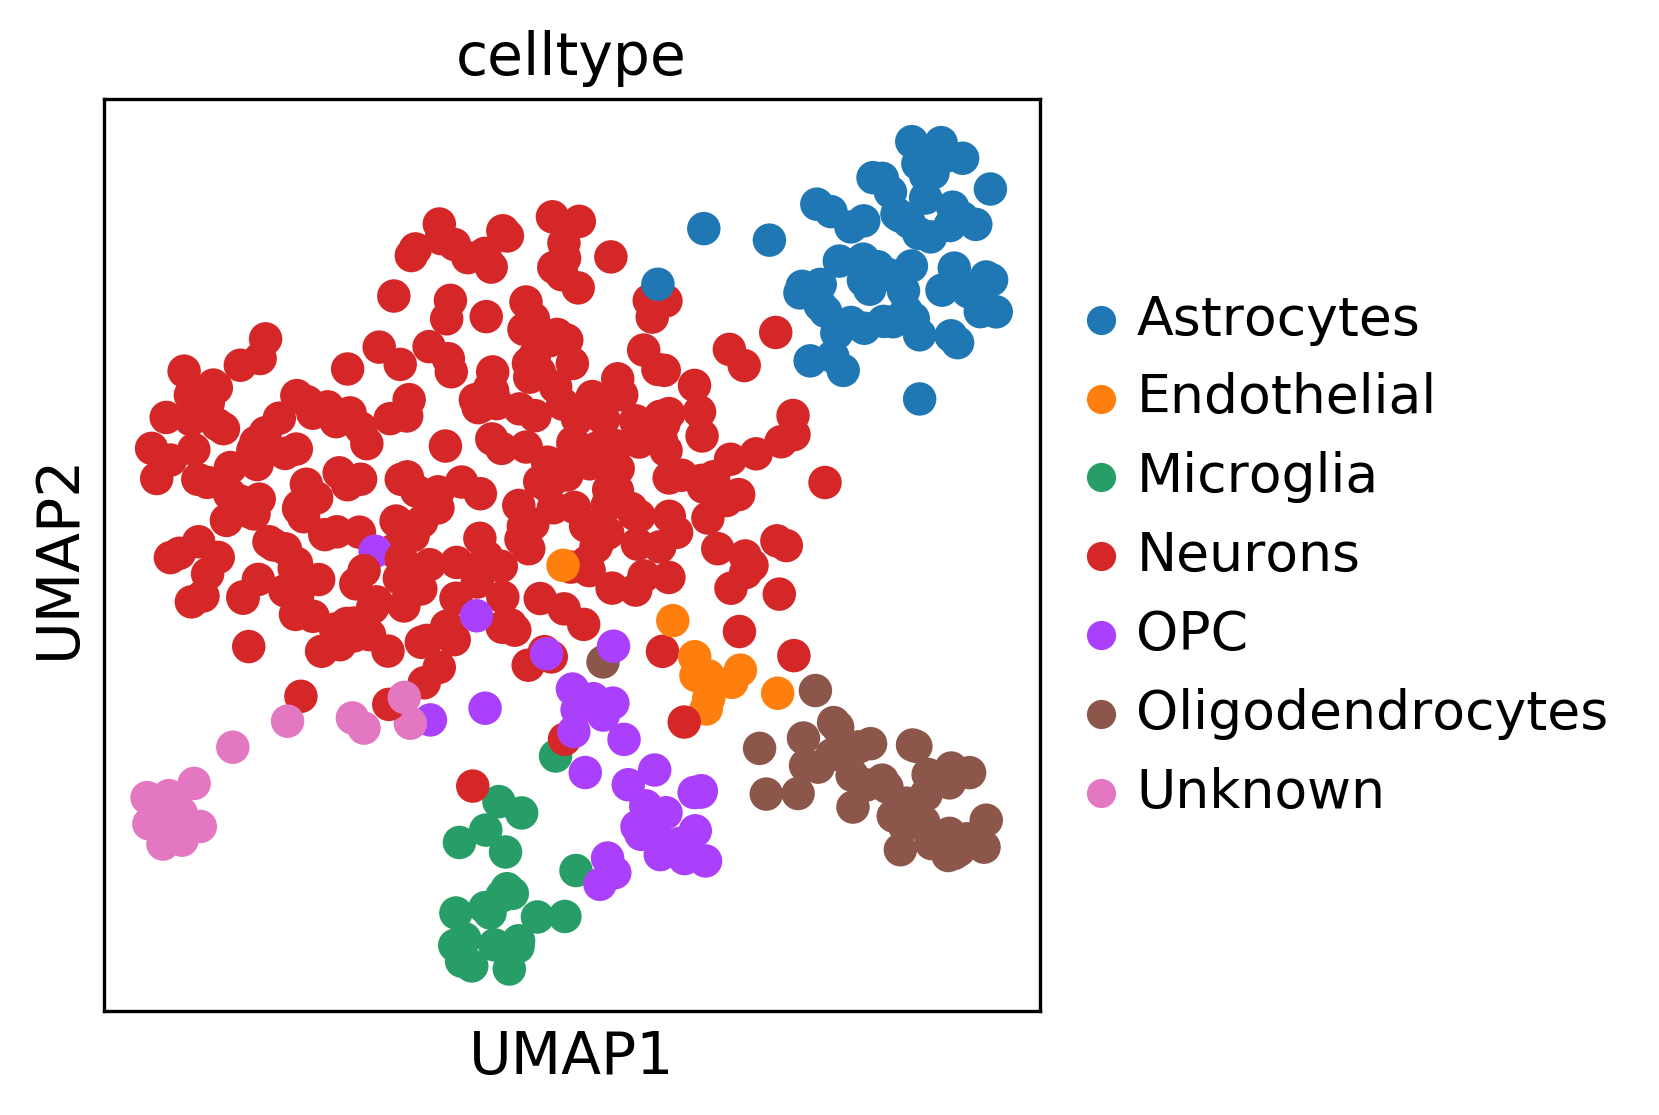

In [32]:
 # Make new category
celltypes = pd.DataFrame(adata.obs['louvain'])
celltypes.louvain.replace(['Neurons', 'Neurons2', 'Neurons3', 'Neurons4','Neurons5', 'Neurons6', 'Neurons7','Neurons8'],
                         ['Neurons', 'Neurons','Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons', 'Neurons'], inplace=True)
adata.obs['celltype'] = celltypes.louvain
sc.pl.umap(adata, color='celltype')

In [33]:
adata

AnnData object with n_obs × n_vars = 465 × 3735 
    obs: 'n_genes', 'n_counts', 'louvain', 'celltype'
    var: 'n_cells'
    uns: 'neighbors', 'louvain', 'louvain_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'

# Calculate cell-type specificity values

Calculate the avarage expression of every gene for each cell type, and then derive the cell type specificity values from that. These are defined as the per-cell-type percentage of total gene expression of a given gene in a equal cell type compsition (same fractions for all cell types).

In [86]:
# Assure that all fractions sum up to 1
def normalize(mat):
    csums = mat.apply(sum, axis=0)
    for i in range(mat.shape[1]):
        mat.iloc[:,i] = mat.iloc[:,i]/csums[i]
    
    return mat

In [87]:
df['celltype'] = list(adata.obs['celltype'])
ct_mean = df.groupby('celltype').mean()
ct_mean = normalize(ct_mean)

In [89]:
ct_mean.shape

(7, 18142)

In [90]:
ct_mean.to_csv(out_path + "darmanis_cell_type_specificity.txt", sep="\t")